In [38]:
import numpy as np
import pandas as pd
import json

import matplotlib 
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, classification_report
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split
import seaborn as sns


import time

plt.style.use('seaborn-white')
sns.set_theme(style="whitegrid")
sns.set_style("whitegrid", {'legend.frameon':True})

/tmp/ipykernel_15209/951817621.py:18: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


In [9]:
from dataclasses import dataclass


@dataclass
class OutputData:
    features: pd.DataFrame
    output: pd.DataFrame


def get_dataset(path: str):
    f = open(path)
    data = json.load(f)
    f.close()
    return data

In [19]:
json_dataset = get_dataset('./datasets/data_1000.json')
df = pd.json_normalize(json_dataset)

columns_rename = {
    ## service params
    'inp.services.cv': 'services_cv',
    'inp.services.skew': 'services_skew',
    'inp.services.rate_min': 'services_rate_min',
    'inp.services.rate_max': 'services_rate_max',
    ## arrival params
    'inp.arrival.skew': 'arrival_skew',
    'inp.arrival.cv': 'arrival_cv',
    'inp.arrival.rate': 'arrival_rate',
    ## num servers
    'inp.num_servers': 'num_servers',
    ## capacity
    'inp.capacity': 'capacity',
    ## meta info
    'meta.fitted.arrival_cv': 'meta_arrival_cv',
    'meta.fitted.arrival_skew': 'meta_arrival_skew',
    'meta.fitted.arrival_lag': 'meta_arrival_lag',
    'meta.fitted.arrival_cv': 'meta_arrival_cv',
    'meta.fitted.arrival_order': 'meta_arrival_order',
    'meta.fitted.service_cv': 'meta_service_cv',
    'meta.fitted.service_skew': 'meta_service_skew',
    'meta.fitted.service_order': 'meta_service_order',
    ## output
    'out.max_system_size.avg': 'out_max_system_size_avg',
    'out.max_system_size.std': 'out_max_system_size_std',
    'out.max_system_size.index': 'out_max_system_size_index',
    'out.min_system_size.avg': 'out_min_system_size_avg',
    'out.min_system_size.std': 'out_min_system_size_std',
    'out.min_system_size.index': 'out_min_system_size_index',
    'out.max_busy_rate.avg': 'out_max_busy_rate_avg',
    'out.max_busy_rate.std': 'out_max_busy_rate_std',
    'out.max_busy_rate.index': 'out_max_busy_rate_index',
    'out.min_busy_rate.avg': 'out_min_busy_rate_avg',
    'out.min_busy_rate.std': 'out_min_busy_rate_std',
    'out.min_busy_rate.index': 'out_min_busy_rate_index',
    'out.loss_prob': 'out_los_prob',
    'out.response_time.avg': 'out_response_time_avg',
    'out.response_time.std': 'out_response_time_std',
    'out.response_time.index': 'out_response_time_index'
}

df = df.rename(columns=columns_rename, inplace=False)
df

data = OutputData(
    features=df[['services_cv', 
                 'services_skew', 
                 'services_rate_min', 
                 'services_rate_max',
                 'arrival_skew',
                 'arrival_cv',
                 'arrival_rate',
                 'num_servers',
                 'capacity'
    ]],
    output=df[['out_response_time_avg',
               'out_min_busy_rate_avg',
               'out_max_busy_rate_avg',
               'out_los_prob',
               'out_max_system_size_avg',
               'out_min_system_size_avg',
    ]]
)

## TODO remove input_type and lag from df

In [28]:
COLORS_MAP = {
    'green': ["Greens", 'lightgreen'],
    'blue': ["Blues", 'lightblue'],
    'orange': ["Oranges", "#fed8b1"],
    'purple': ['Purples', '#D8BFD8']
}


def build_estimates_tests_scatter(estimations, predictions,
                                  name="", 
                                  rang=[0, 10], 
                                  divider=1,
                                  xlabel='samples_s', 
                                  ylabel='sstimates_s',
                                  color='blue'):
    
    fig , ax = plt.subplots(figsize=(6, 6))
    cm = plt.get_cmap(COLORS_MAP.get(color)[0])
    col = [cm(1 / abs(predictions[i] - estimations[i])/divider) for i in range(len(estimations))]
    plt.scatter(predictions, estimations, c=col, marker='^')
    x = np.linspace(rang[0], rang[1])
    plt.plot(x, x, linestyle='-', linewidth=2, color=COLORS_MAP.get(color)[1])
    plt.title('{}'.format(name), fontsize=22, pad=10)
    ax.title.set_fontsize(24)
    plt.xticks()
    plt.tick_params(labelsize=22)
    plt.yticks()

    plt.xlim(rang)
    plt.ylim(rang)

    ax.set_xlabel(xlabel, size=24)
    ax.set_ylabel(ylabel, size=24)

## response time regression

In [25]:
response_time = data.output['out_response_time_avg']
response_time

0      2.778800
1      4.000661
2      6.146147
3      3.429433
4      2.637155
         ...   
995    2.772294
996    7.549977
997    6.769538
998    2.151547
999    3.977001
Name: out_response_time_avg, Length: 1000, dtype: float64

## Regression tree

In [34]:
# decision tree regressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

tree_params = {
                'criterion': ['mse', 'friedman_mse', 'mae', 'poisson'],
                'max_depth':[4,5,6,7,8,9,10,11,12,15,20]
}

gs = GridSearchCV(
    DecisionTreeRegressor(random_state=0),
    tree_params,
    verbose=1,
    cv=10,
    n_jobs=4
)

#regressor = DecisionTreeRegressor(random_state=0)
#cross_val_score(regressor, df, y_busy_services, cv=10)

#gs.fit(df, y_busy_services)

start_time = time.time()
tree = DecisionTreeRegressor(criterion='friedman_mse', max_depth=12)
print("Time for calculation decision tree {}".format(time.time() - start_time))

X_train, X_test, y_train, y_test = train_test_split(data.features, response_time, train_size=0.8)

tree.fit(X_train, y_train)
#print(regression_report(y_test, tree.predict(X_test)))

Time for calculation decision tree 6.747245788574219e-05


DecisionTreeRegressor(criterion='friedman_mse', max_depth=12)

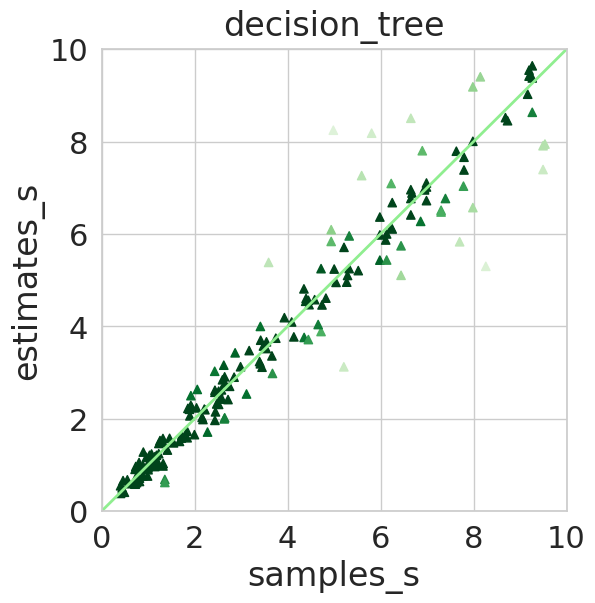

In [39]:
build_estimates_tests_scatter(y_test.values,
                              tree.predict(X_test), 
                              name="decision_tree", 
                              color="green",
                              rang=[0, 10], divider=2, 
                              xlabel="samples_s", 
                              ylabel="estimates_s"
                             )

## Gradient boosting